In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load data
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')
sample_submission = pd.read_csv('../input/sample_submission.csv')

# Merge datasets
df_train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
df_test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# Standardizing column names
df_train.columns = df_train.columns.str.replace('-', '_')
df_test.columns = df_test.columns.str.replace('-', '_')

# 1. Select only numerical columns
X_train = df_train.select_dtypes(include=['number'])
X_test = df_test.select_dtypes(include=['number'])

X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

# 2. Handle the target variable (assuming 'isFraud' is the target)
y_train = df_train['isFraud']  # Target variable


In [18]:
X_train.isnull().sum()
X_test.isnull().sum()

C1              3
C10             3
C11             3
C12             3
C13          4748
            ...  
id_24      501951
id_25      501652
id_26      501644
id_32      436020
isFraud         0
Length: 402, dtype: int64

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 0.86
Validation F1 Score: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    113866
           1       0.99      0.86      0.92      4242

    accuracy                           0.99    118108
   macro avg       0.99      0.93      0.96    118108
weighted avg       0.99      0.99      0.99    118108



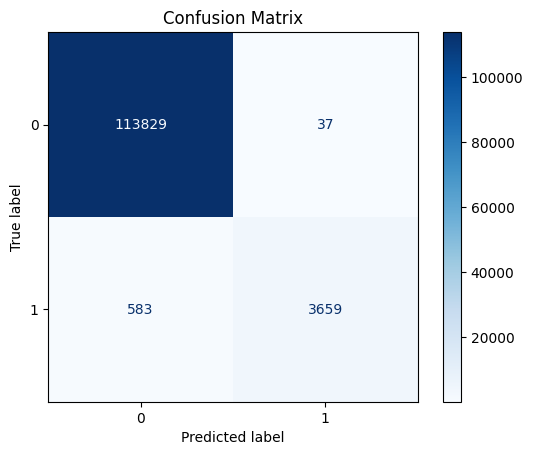

In [1]:
# 3. Preprocess data: Handle missing values (if any)
X_train.fillna(0, inplace=True)  # or you can use df_train.median() for numerical columns
X_test.fillna(0, inplace=True)

# 4. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Split the training data for validation
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# 6. Train the k-NN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune 'k' later
knn.fit(X_train_sub, y_train_sub)

# 7. Validate the model
y_val_pred = knn.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)  # Calculate F1 Score

# Print results
print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Validation Precision: {precision:.2f}")
print(f"Validation Recall: {recall:.2f}")
print(f"Validation F1 Score: {f1:.2f}")  # Print F1 Score

# Show detailed classification report
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap='Blues')  # 'Blues' colormap for better readability
plt.title('Confusion Matrix')
plt.show()
